In [20]:
!pip install opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.8 MB ? eta -:--:--
    --------------------------------------- 0.5/38.8 MB 840.2 kB/s eta 0:00:46
    --------------------------------------- 0.8/38.8 MB 860.9 kB/s eta 0:00:45
   - -------------------------------------- 1.0/38.8 MB 853.0 kB/s eta 0:00:45
   - -------------------------------------- 1.0/38.8 MB 853.0 kB/s eta 0:00:45
   - -------------------------------------- 1.3/38.8 MB 871.6 kB/s eta 0:00:44
   - -------------------------------------- 1.6/38.8 MB 883.2 kB/s eta 0:00:43
   - -------------------------------------- 1.8/38.8 MB 898.8 kB/s eta 0:00:42
   - -------------------------------------- 1.8/38.8 MB 898.8 kB/s eta 0:00:42
   -- ----

In [6]:
import cv2 
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Flatten,Dense
import tensorflow as tf
import uuid
from tensorflow.keras.metrics import Precision,Recall

In [8]:
#Avoid Out of Memory error Gpu
# gpus=tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
    # tf.config.experimental.set_memory_growth(gpu,True)

In [9]:
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

In [5]:
#directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [6]:
!tar -xf lfw.tgz

In [10]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH=os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\4b49b60d-4f73-11ef-81da-387a0e176249.jpg'

In [12]:
cap= cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame[120:120+250,200:200+250,:]

    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname=os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname=os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    cv2.imshow('Image Collection',frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [13]:
anchor = tf.data.Dataset.list_files(rf'{ANC_PATH}\*.jpg').take(300)
positive = tf.data.Dataset.list_files(rf'{POS_PATH}\*.jpg').take(300)
negative = tf.data.Dataset.list_files(rf'{NEG_PATH}\*.jpg').take(300)

In [14]:
dir_test=anchor.as_numpy_iterator()

In [15]:
dir_test.next()

b'data\\anchor\\1df2bf1b-4f48-11ef-9881-387a0e176249.jpg'

In [16]:
def preprocess(file_path):
    # Ensure file_path is a string
    file_path = tf.strings.as_string(file_path)
    
    byte_img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, [100, 100])
    img = img / 255.0  # Normalize to [0, 1]
    
    return img

In [17]:
img = preprocess('data\\anchor\\0ec62723-4f47-11ef-92c2-387a0e176249.jpg')

In [18]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [19]:
samples=data.as_numpy_iterator()

In [20]:
example=samples.next()

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)
# def preprocess_twin(input_img, validation_img, label):
#     input_img = preprocess(input_img)
#     validation_img = preprocess(validation_img)
#     return input_img, validation_img, label

In [218]:
res = preprocess_twin(*example)

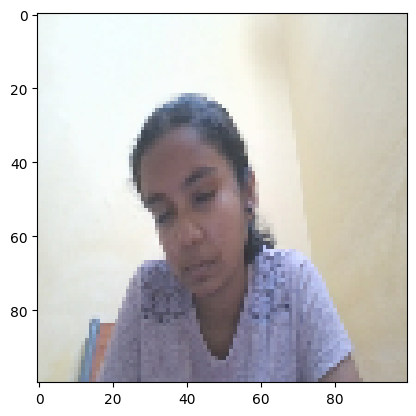

In [219]:
plt.imshow(res[1])

In [220]:
res[2]

1.0

In [22]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [23]:
sample=data.as_numpy_iterator()

In [24]:
samp=sample.next()

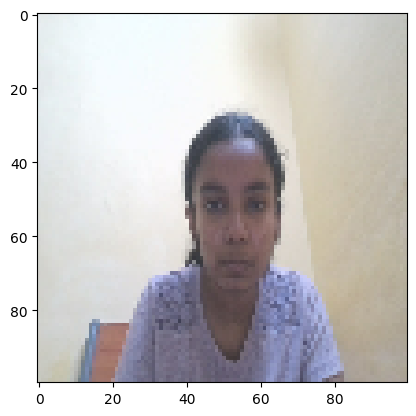

In [109]:
#erase next 2 cells along wih this
plt.imshow(samp[0])

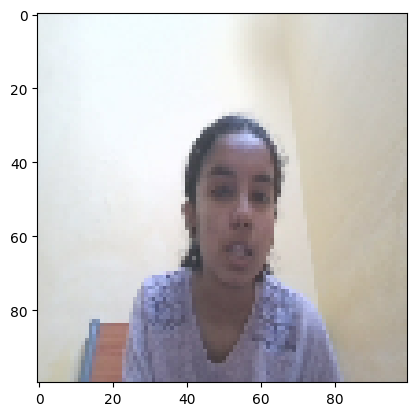

In [110]:
plt.imshow(samp[1])

In [111]:
samp[2]

1.0

In [25]:
train_data=data.take(round(len(data)*0.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [26]:
train_samples=train_data.as_numpy_iterator()

In [27]:
train_sample=train_samples.next()

In [115]:
len(train_sample[0])

16

In [28]:
test_data=data.skip(round(len(data)*0.7))
test_data=test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data=test_data.prefetch(8)

In [29]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)

    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)

    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)

    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    
    d1=Dense(4096,activation='sigmoid')(f1)
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [30]:
embedding=make_embedding()

In [123]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self,input_embedding,validation_embedding):
        input_embedding=tf.convert_to_tensor(input_embedding)
        validation_embedding=tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)
    def comput_output_shape(self,input_shape):
        return input_shape[0]

In [32]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [33]:
siamese_model = make_siamese_model()

In [192]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_27 (L1Dist)           │ (1, None, 4096)           │               0 │ embedding[42][0],          │
│                               │                           │                 │ embedding[43][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (1, None, 1)              │           4,097 │ l1_dist_27[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [35]:
opt=tf.keras.optimizers.Adam(1e-4)

In [36]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [37]:
test_batch=train_data.as_numpy_iterator()

In [38]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X=batch[:2]
        y=batch[2]
        yhat=siamese_model(X,training=True)
        yhat = tf.reshape(yhat, tf.shape(y))
        loss=binary_cross_loss(y,yhat)
    print(loss)
    grad=tape.gradient(loss,siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))

    return loss

In [4]:
def train(data,EPOCHS):
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch{}/{}'.format(epoch,EPOCHS))
        progbar=tf.keras.utils.Progbar(len(data))
        for idx,batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [244]:
EPOCHS=50

In [245]:
train(train_data,EPOCHS)


 Epoch1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepTensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step

 Epoch2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step

 Epoch3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step

 Epoch4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step

 Epoch5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step

 Epoch6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 173s 6s/step

 Epoch7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step

 Epoch8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step

 Epoch9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 160s 6s/step

 Epoch10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 167s 6s/step

 Epoch11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step

 Epoch12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step

 Epoch13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step

 Epoch14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 154s 6s/step

 Epoch15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 142s

In [39]:
test_input,test_val,y_true=test_data.as_numpy_iterator().next()

In [40]:
yhat=siamese_model.predict([test_input,test_val])
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[[0.50030744],
        [0.5008081 ],
        [0.50088847],
        [0.49932057],
        [0.5002853 ],
        [0.5010601 ],
        [0.50117224],
        [0.5014316 ],
        [0.50082225],
        [0.49967283],
        [0.49970722],
        [0.5004876 ],
        [0.5012718 ],
        [0.50038195],
        [0.50066084],
        [0.5002195 ]]], dtype=float32)

In [43]:
yhat_flattened = yhat.flatten()
yhat_binary = [1 if prediction > 0.5 else 0 for prediction in yhat_flattened]

In [44]:
y_true

array([1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [46]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, yhat)

# Return Recall Result
m.result().numpy()

0.75

In [48]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, yhat)

# Return Recall Result
m.result().numpy()

0.23076923

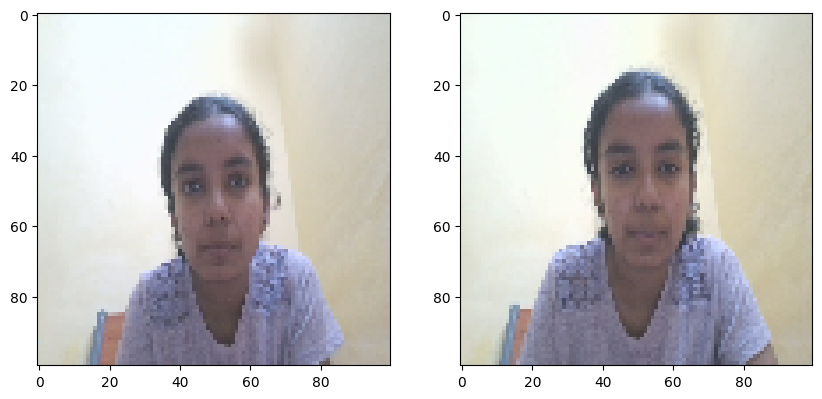

In [49]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [54]:
# siamese_model.save('siamesemodel.h5')
model.save('siamesemodel.keras')

In [55]:
model = tf.keras.models.load_model('siamesemodel.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [56]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[[0.50030744],
        [0.5008081 ],
        [0.50088847],
        [0.49932057],
        [0.5002853 ],
        [0.5010601 ],
        [0.50117224],
        [0.5014316 ],
        [0.50082225],
        [0.49967283],
        [0.49970722],
        [0.5004876 ],
        [0.5012718 ],
        [0.50038195],
        [0.50066084],
        [0.5002195 ]]], dtype=float32)

In [57]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (1, None, 4096)           │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (1, None, 1)              │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
os.listdir(os.path.join('application_data', 'verification_images'))

['00b8fcd1-4f49-11ef-8830-387a0e176249.jpg',
 '00e3e5a4-4f49-11ef-9e23-387a0e176249.jpg',
 '01b6bbc6-4f49-11ef-9b7b-387a0e176249.jpg',
 '01ccbad8-4f49-11ef-a041-387a0e176249.jpg',
 '01e1c16d-4f49-11ef-b04f-387a0e176249.jpg',
 '03f47da9-4f49-11ef-8ba3-387a0e176249.jpg',
 '04b06054-4f49-11ef-90eb-387a0e176249.jpg',
 '04feb02a-4f49-11ef-afff-387a0e176249.jpg',
 '05e8a4e3-4f49-11ef-a9d3-387a0e176249.jpg',
 '06b6121a-4f49-11ef-9e6e-387a0e176249.jpg',
 '0a3ab9f1-4f49-11ef-95fb-387a0e176249.jpg',
 '0abd1919-4f49-11ef-9746-387a0e176249.jpg',
 '0b0e2959-4f49-11ef-b3ef-387a0e176249.jpg',
 '0b472440-4f49-11ef-a2aa-387a0e176249.jpg',
 '0b7d3160-4f49-11ef-a75e-387a0e176249.jpg',
 '0bb422e0-4f49-11ef-af0e-387a0e176249.jpg',
 '0c36a2fe-4f49-11ef-b15d-387a0e176249.jpg',
 '0cbabee7-4f49-11ef-b9bf-387a0e176249.jpg',
 '0d0af787-4f49-11ef-9bc5-387a0e176249.jpg',
 '0d5208ef-4f49-11ef-bc4a-387a0e176249.jpg',
 '0d9ff559-4f49-11ef-aa9d-387a0e176249.jpg',
 '0dc4e8b0-4f49-11ef-97b6-387a0e176249.jpg',
 '0e612afe

In [81]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [82]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\00b8fcd1-4f49-11ef-8830-387a0e176249.jpg
application_data\verification_images\00e3e5a4-4f49-11ef-9e23-387a0e176249.jpg
application_data\verification_images\01b6bbc6-4f49-11ef-9b7b-387a0e176249.jpg
application_data\verification_images\01ccbad8-4f49-11ef-a041-387a0e176249.jpg
application_data\verification_images\01e1c16d-4f49-11ef-b04f-387a0e176249.jpg
application_data\verification_images\03f47da9-4f49-11ef-8ba3-387a0e176249.jpg
application_data\verification_images\04b06054-4f49-11ef-90eb-387a0e176249.jpg
application_data\verification_images\04feb02a-4f49-11ef-afff-387a0e176249.jpg
application_data\verification_images\05e8a4e3-4f49-11ef-a9d3-387a0e176249.jpg
application_data\verification_images\06b6121a-4f49-11ef-9e6e-387a0e176249.jpg
application_data\verification_images\0a3ab9f1-4f49-11ef-95fb-387a0e176249.jpg
application_data\verification_images\0abd1919-4f49-11ef-9746-387a0e176249.jpg
application_data\verification_images\0b0e2959-4f49-11ef-b3ef-387

In [83]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [86]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.6)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
np.sum(np.squeeze(results) > 0.9)